In [7]:
#! Note: Taken from https://hef.ru.nl/~tbudd/mct/lectures/cluster_algorithms.html
# Copyright: Timothy Budd

import numpy as np

rng = np.random.default_rng()
import json
import time

import matplotlib.pylab as plt

%matplotlib inline


def aligned_init_config(width):
    """Produce an all +1 configuration."""
    return np.ones((width, width), dtype=int)


def plot_ising(config, ax, title):
    """Plot the configuration."""
    ax.matshow(config, vmin=-1, vmax=1, cmap=plt.cm.binary)
    ax.title.set_text(title)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_xticks([])


from collections import deque


def neighboring_sites(s, w):
    """Return the coordinates of the 4 sites adjacent to s on an w*w lattice."""
    return [
        ((s[0] + 1) % w, s[1]),
        ((s[0] - 1) % w, s[1]),
        (s[0], (s[1] + 1) % w),
        (s[0], (s[1] - 1) % w),
    ]


def cluster_flip(state, seed, p_add):
    """Perform a single Wolff cluster move with specified seed on the state with parameter p_add."""
    w = len(state)
    spin = state[seed]
    state[seed] = -spin
    cluster_size = 1
    unvisited = deque(
        [seed]
    )  # use a deque to efficiently track the unvisited cluster sites
    while unvisited:  # while unvisited sites remain
        site = unvisited.pop()  # take one and remove from the unvisited list
        for nbr in neighboring_sites(site, w):
            if state[nbr] == spin and rng.uniform() < p_add:
                state[nbr] = -spin
                unvisited.appendleft(nbr)
                cluster_size += 1
    return cluster_size


def wolff_cluster_move(state, p_add):
    """Perform a single Wolff cluster move on the state with addition probability p_add."""
    seed = tuple(rng.integers(0, len(state), 2))
    return cluster_flip(state, seed, p_add)

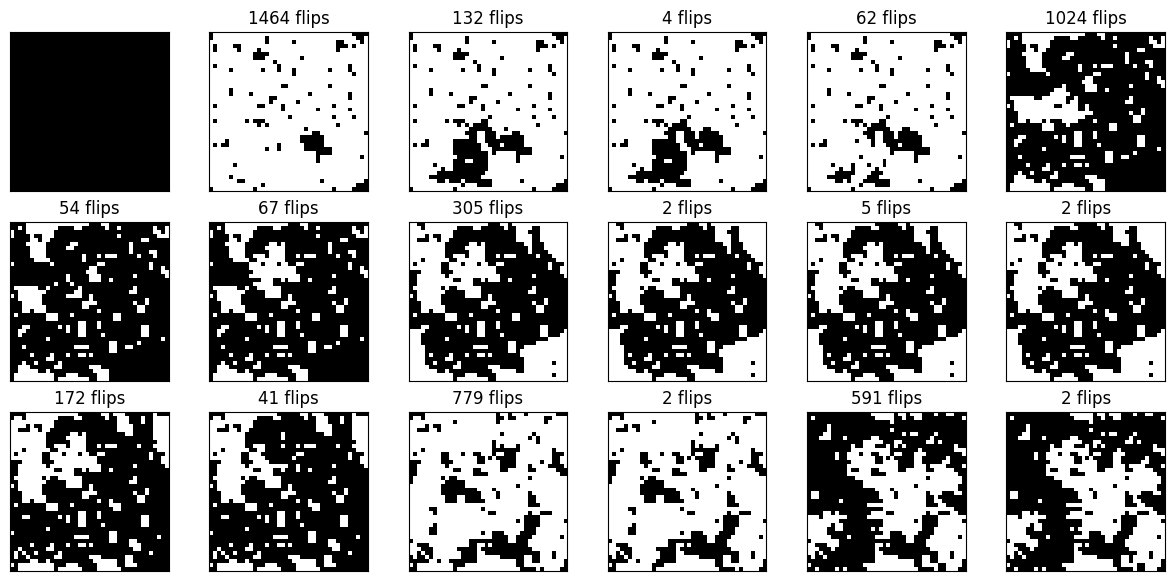

In [8]:
width = 40
temperature = 2.4
p_add = 1 - np.exp(-2 / temperature)
config = aligned_init_config(width)
fig, axs = plt.subplots(3, 6, figsize=(15, 7))
flips = 0
for axrow in axs:
    for ax in axrow:
        plot_ising(config, ax, f"{flips} flips" if flips > 0 else "")
        flips = wolff_cluster_move(config, p_add)

In [9]:
def compute_magnetization(config):
    """Compute the magnetization M(s) of the state config."""
    return np.sum(config)


def run_ising_wolff_mcmc(state, p_add, n):
    """Run n Wolff moves on state and return total number of spins flipped."""
    total = 0
    for _ in range(n):
        total += wolff_cluster_move(state, p_add)
    return total


temperatures = np.linspace(0.9 * 2, 1.4 * 2, 96 // 4)
equil_moves = 1000

sizes_to_test = [16, 24, 32, 48, 64]
flip_rates = {}

for size in sizes_to_test:
    total_flips = 0
    time_start = time.time()
    print(f"Doing {size}")
    for temp in temperatures:
        p_add = 1 - np.exp(-2 / temp)
        state = aligned_init_config(size)
        total_flips += run_ising_wolff_mcmc(state, p_add, equil_moves)

    time_spent = time.time() - time_start
    flip_rate = total_flips / (time_spent * 1e6)
    flip_rates[size] = flip_rate

Doing 16
Doing 24
Doing 32
Doing 48
Doing 64


In [18]:
display(flip_rates)
import json
from pathlib import Path

fp = Path().resolve() / "experiments" / "performance" / "tbudd_wolff_perf.json"
with open(fp, "w") as f:
    json.dump(flip_rates, f)

{16: 0.18590541232457436,
 24: 0.18988095816442507,
 32: 0.19098310110241357,
 48: 0.19240785937976587,
 64: 0.1928707448148292}